In [1]:
import os, joblib, pandas as pd, numpy as np
import xgboost as xgb
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score

DATA_DIR = os.path.join('.', 'dataset')

In [2]:
X_train = pd.read_csv(f'{DATA_DIR}/X_train_pre.csv', index_col=0)
y_train = pd.read_csv(f'{DATA_DIR}/y_train_pre.csv', index_col=0)['label']

X_val   = pd.read_csv(f'{DATA_DIR}/X_test_pre.csv',  index_col=0)
y_val   = pd.read_csv(f'{DATA_DIR}/y_test_pre.csv',  index_col=0)['label']

print('Train shape:', X_train.shape, '  Val shape:', X_val.shape)

Train shape: (18819, 18)   Val shape: (8066, 18)


In [3]:
# Convert class name 1-5 to 0-4 which is required by XGBoost

y_tr_xgb = (y_train - 1).astype(int)
y_val_xgb = (y_val   - 1).astype(int)

dtrain = xgb.DMatrix(X_train, label=y_tr_xgb)
dval   = xgb.DMatrix(X_val,   label=y_val_xgb)

In [4]:
params = {
    'objective':        'multi:softprob',
    'num_class':        5,
    'eval_metric':      'mlogloss',
    'eta':              0.05,
    'max_depth':        6,
    'subsample':        0.9,
    'colsample_bytree': 0.8,
    'seed':             42
}

model = xgb.train(
    params, dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=50,
    verbose_eval=50
)

print('Best iteration:', model.best_iteration)


[0]	train-mlogloss:1.49603	val-mlogloss:1.49646
[50]	train-mlogloss:0.13976	val-mlogloss:0.14585
[100]	train-mlogloss:0.02683	val-mlogloss:0.03314
[150]	train-mlogloss:0.00858	val-mlogloss:0.01448
[200]	train-mlogloss:0.00383	val-mlogloss:0.00990
[250]	train-mlogloss:0.00213	val-mlogloss:0.00849
[300]	train-mlogloss:0.00142	val-mlogloss:0.00785
[350]	train-mlogloss:0.00106	val-mlogloss:0.00755
[400]	train-mlogloss:0.00086	val-mlogloss:0.00741
[450]	train-mlogloss:0.00073	val-mlogloss:0.00733
[500]	train-mlogloss:0.00065	val-mlogloss:0.00729
[550]	train-mlogloss:0.00059	val-mlogloss:0.00723
[600]	train-mlogloss:0.00054	val-mlogloss:0.00720
[650]	train-mlogloss:0.00051	val-mlogloss:0.00714
[700]	train-mlogloss:0.00048	val-mlogloss:0.00713
[750]	train-mlogloss:0.00045	val-mlogloss:0.00712
[800]	train-mlogloss:0.00043	val-mlogloss:0.00708
[850]	train-mlogloss:0.00041	val-mlogloss:0.00704
[900]	train-mlogloss:0.00040	val-mlogloss:0.00704
[906]	train-mlogloss:0.00040	val-mlogloss:0.00705
Bes

Weighted-F1: 0.998140148844453
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      1613
           2       1.00      1.00      1.00      1613
           3       1.00      1.00      1.00      1613
           4       1.00      1.00      1.00      1613
           5       1.00      1.00      1.00      1614

    accuracy                           1.00      8066
   macro avg       1.00      1.00      1.00      8066
weighted avg       1.00      1.00      1.00      8066



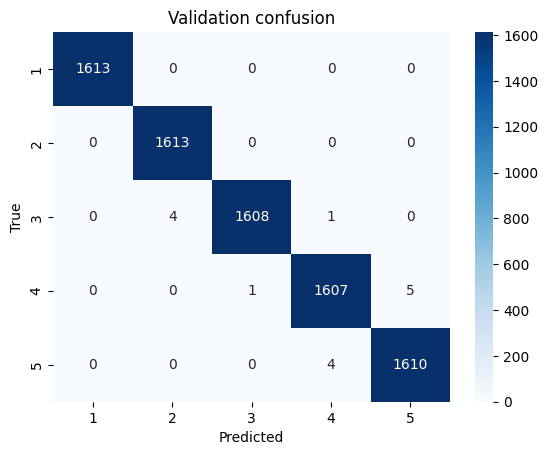

In [5]:
y_pred = np.argmax(model.predict(dval), axis=1) + 1   # back to 1-5
print('Weighted-F1:', f1_score(y_val, y_pred, average='weighted'))
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred, labels=[1,2,3,4,5])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Validation confusion'); plt.show()


In [6]:
MODEL_PATH = f'{DATA_DIR}/../xgb_ripeness_stage5.pkl'
joblib.dump(model, MODEL_PATH)

with open(f'{DATA_DIR}/../model_features.txt', 'w') as f:
    for col in X_train.columns: f.write(col + '\n')

print('Model saved →', MODEL_PATH)
print('Feature list saved → model_features.txt')

Model saved → .\dataset/../xgb_ripeness_stage5.pkl
Feature list saved → model_features.txt
